# ID2222 Data Mining - Homework 3

Notebook by Beatrice Insalata, Laura Puccioni

This homework is based on the paper "TRIÈST: Counting Local and Global Triangles in Fully-Dynamic Streams with Fixed Memory Size". The paper presents a suite of one-pass streaming algorithms to compute unbiased, low-variance, high-quality approximations of the global and local number of triangles in a fully dynamic graphs represented as an adversarial stream of edge insertions and deletions.

## Dataset
The dataset we decided to use for this task is facebook_combined.txt, which consists of cricles (or friends lists) from Facebook. It is an undirected containing a total of 4039 nodes and 88234 edges.

In [97]:
file_path = 'facebook_combined.txt'

edges = set()

try:
    with open(file_path, 'r') as file:
        for line in file:
            if '#' in line: #Skip the comment lines
                continue
            else:
                edge = tuple(line.replace("\n","").split(" "))
                edges.add(edge)
except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

An examle of 10 lines of the dataset can be seen below, representing edges between two nodes.

In [98]:
for i in range(0,10):
    print(list(edges)[i])

('2250', '2400')
('597', '636')
('2271', '2430')
('2069', '2606')
('465', '669')
('1563', '1683')
('1668', '1707')
('1714', '1846')
('1918', '2069')
('3540', '3684')


## TRIÈST Algorithm
The paper analysed presents two versions of the Triest Algorithm, a basic one and an improved one for higher-quality estimations. The implementation of both algorithms can be found below.

### Trièst Algorithm - Basic Version
The class Triest_base contains functions that are needed to run the basic version of the algorithm:
- The sample_edge function is the one designated to the decision of whether to insert or not a new sample. If the limit M of possible edges present in the edge sample S has not been reached yet (t<=M), the new edge is inserted. Otherwise (t>M), a biased coin with heads probability M/t is flipped:
    - If the outcome is heads, an edge (w,s) ∈ S is chosen uniformly at random and is removed from S, while the new edge is inserted in S.
    - If the outcome is tail, S is not modified.
- The update_counters function is responsible for counting the number of triangles, updating both the global counter and the local counters of the new nodes and their neighbours.
- The function get_common_neighbourhood, is the one returning the common neighbours of the new edge.
- The run function is the one responsible for running the algorithm on a dataset.

In [99]:
import random
import operator

class Triest_base():
    def __init__(self, M):
        self.S = set()
        self.t = 0
        self.tau = 0
        self.tau_count = {}
        self.M = M

    def sampleEdge(self,edge):
        if self.t<=self.M:
            return True
        elif random.random() < (self.M / self.t):
            random_edge = random.choice(tuple(self.S))
            self.S.remove(random_edge)
            self.updateCounters(operator.sub, random_edge)
            return True
        else:
            return False

    def updateCounters(self,operator,edge):
        u=edge[0]
        v=edge[1]

        common_neighbours = self.get_common_neighbours(edge)

        for c in common_neighbours:
            self.tau = operator(self.tau,1)
            self.tau_count[c] = operator(int(self.tau_count.get(c) or 0),1)
            self.tau_count[u] = operator(int(self.tau_count.get(u) or 0),1)
            self.tau_count[v] = operator(int(self.tau_count.get(v) or 0),1)

    def get_common_neighbours(self, edge):
        u=edge[0]
        v=edge[1]

        neighbours_u = set()
        neighbours_v = set()

        for elem in self.S:
            if u == elem[0]:
                neighbours_u.add(elem[1])
            if u == elem[1]:
                neighbours_u.add(elem[0])
            if v == elem[0]:
                neighbours_v.add(elem[1])
            if v == elem[1]:
                neighbours_v.add(elem[0])

        return neighbours_v & neighbours_u

    def run(self, dataset):
        for edge in dataset:
            #print(edge)
            self.t = self.t + 1
            if self.t % 2000 == 0:
                print("t:",self.t,"tau:",self.tau)
            if self.sampleEdge(edge):
                self.S.add(edge)
                #print(self.S)
                self.updateCounters(operator.add,edge)

        eps = (self.t*(self.t-1)*(self.t-2))/(self.M*(self.M-1)*(self.M-2))

        if eps < 1:
            eps = 1

        return self.tau*eps


To understand if the algorithm works properly, we can try it on a small graph. We can start with the following undirected graph:

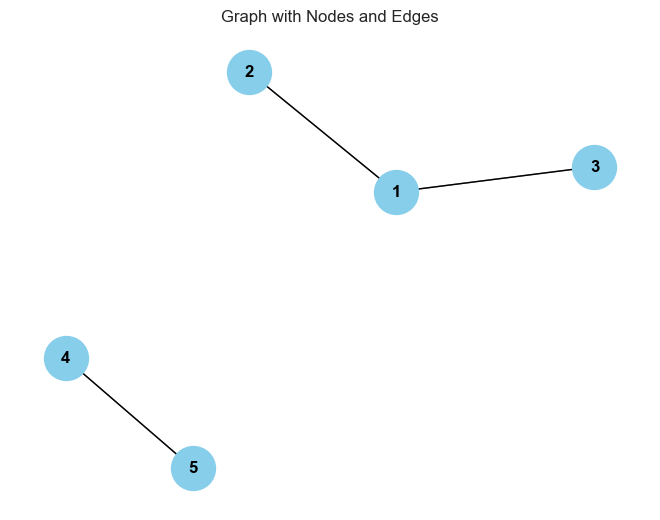

In [126]:
from matplotlib import pyplot as plt
import networkx as nx

example_graph = {(1,2), (3,1), (4,5)}
G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)

# Add edges
G.add_edge(1, 2)
G.add_edge(3, 1)
G.add_edge(4, 5)

k_value = 1.5  # Adjust this value to your preference
pos = nx.spring_layout(G, k=k_value)
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold', node_size=1000, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='black')

# Show the graph
plt.title("Graph with Nodes and Edges")
plt.axis('off')  # Disable axis display
plt.show()

We can see that there are no triangles, therefore our algorithm correctly returns 0 as the number of triangles in the graph:

In [140]:
base = Triest_base(3)
print("The estimated number of triangles estimated is:", base.run(example_graph))

The estimated number of triangles estimated is: 0.0


We keep tryng with new nodes and new edges, to be sure that the algorithm works properly.

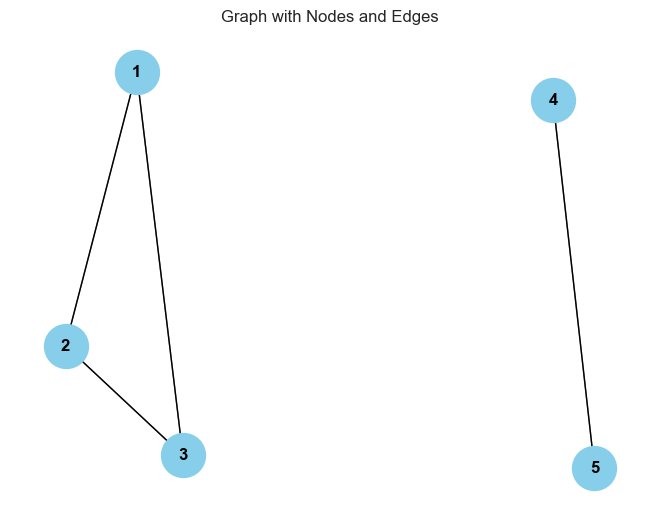

In [141]:
example_graph = {(1,2), (3,2), (3,1), (4,5)}
G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)

# Add edges
G.add_edge(1, 2)
G.add_edge(3, 2)
G.add_edge(3, 1)
G.add_edge(4, 5)

k_value = 1.5  # Adjust this value to your preference
pos = nx.spring_layout(G, k=k_value)
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold', node_size=1000, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='black')

# Show the graph
plt.title("Graph with Nodes and Edges")
plt.axis('off')  # Disable axis display
plt.show()

Given this graph and M = 4 = #edges, our algorithm correctly returns 1 as the number of triangles in the graph:

In [142]:
base = Triest_base(5)
print("The estimated number of triangles estimated is:", base.run(example_graph))

The estimated number of triangles estimated is: 1


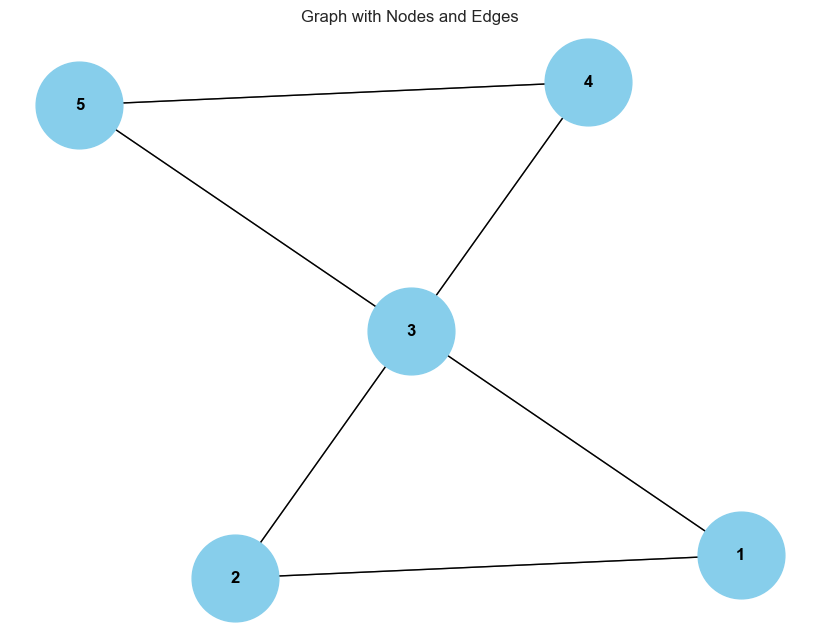

In [130]:
example_graph = {(1,2), (3,2), (3,1), (4,5), (4,3), (3,5)}
G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)

# Add edges
G.add_edge(1, 2)
G.add_edge(3, 2)
G.add_edge(3, 1)
G.add_edge(4, 5)
G.add_edge(4, 3)
G.add_edge(3, 5)

plt.figure(figsize=(8, 6))
# Draw the graph
pos = nx.spring_layout(G)  # Positions of the nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold', node_size=3900, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='black')

# Show the graph
plt.title("Graph with Nodes and Edges")
plt.axis('off')  # Disable axis display
plt.show()

Here the algrithm correctly returns 2 as the number of triangles:

In [143]:
base = Triest_base(6)
print("The number of triangles are:", base.run(example_graph))

The number of triangles are: 1


With a more complicated graph:

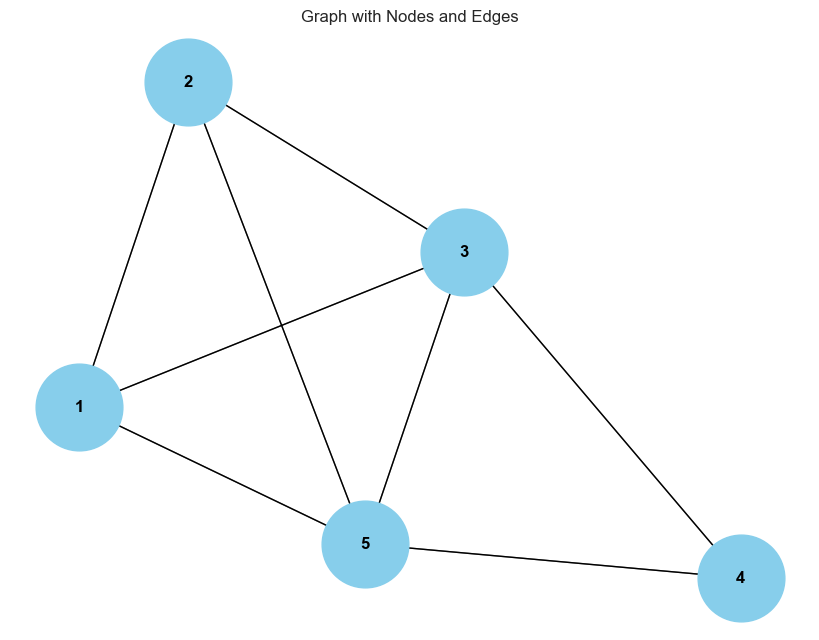

In [144]:
example_graph = {(1,2), (3,2), (3,1), (4,5), (4,3), (3,5), (2,5), (5,1)}
G = nx.Graph()
# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)
G.add_node(4)
G.add_node(5)

# Add edges
G.add_edge(1, 2)
G.add_edge(3, 2)
G.add_edge(3, 1)
G.add_edge(4, 5)
G.add_edge(4, 3)
G.add_edge(3, 5)
G.add_edge(2, 5)
G.add_edge(5, 1)

plt.figure(figsize=(8, 6))
# Draw the graph
pos = nx.spring_layout(G)  # Positions of the nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', font_weight='bold', node_size=3900, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='black')

# Show the graph
plt.title("Graph with Nodes and Edges")
plt.axis('off')  # Disable axis display
plt.show()

In this case the triangles are formed by:
- (1,2,3)
- (1,3,5)
- (3,4,5)
- (2,3,5)
- (1,2,5)

So, our algorithm should return 5.

In [145]:
base = Triest_base(8)
print("The number of triangles are:", base.run(example_graph))

The number of triangles are: 5.0


Now we can try the algorithm on the whole dataset of Facebook circles. As can be seen below, the number of triangles found is 1,612,010, which is coherent with the Dataset Statistics that can be found [here](https://snap.stanford.edu/data/ego-Facebook.html)

In [146]:
base = Triest_base(88234)
print("The estimated number of triangles estimated is:", base.run(edges))

t: 2000 tau: 10
t: 4000 tau: 155
t: 6000 tau: 455
t: 8000 tau: 971
t: 10000 tau: 1973
t: 12000 tau: 3382
t: 14000 tau: 5501
t: 16000 tau: 8261
t: 18000 tau: 12275
t: 20000 tau: 17138
t: 22000 tau: 23068
t: 24000 tau: 30193
t: 26000 tau: 38607
t: 28000 tau: 48411
t: 30000 tau: 60475
t: 32000 tau: 73635
t: 34000 tau: 89243
t: 36000 tau: 106575
t: 38000 tau: 126186
t: 40000 tau: 146608
t: 42000 tau: 170143
t: 44000 tau: 196919
t: 46000 tau: 226438
t: 48000 tau: 257920
t: 50000 tau: 291624
t: 52000 tau: 327118
t: 54000 tau: 367080
t: 56000 tau: 410868
t: 58000 tau: 456234
t: 60000 tau: 504477
t: 62000 tau: 555198
t: 64000 tau: 612144
t: 66000 tau: 671227
t: 68000 tau: 735134
t: 70000 tau: 801136
t: 72000 tau: 870535
t: 74000 tau: 944669
t: 76000 tau: 1025798
t: 78000 tau: 1109843
t: 80000 tau: 1196113
t: 82000 tau: 1288927
t: 84000 tau: 1388122
t: 86000 tau: 1489935
t: 88000 tau: 1598708
The estimated number of triangles estimated is: 1612010.0


In [147]:
#TO DO --> ADD graphs and statistics by changin M

### Trièst Algorithm - Improved Version
Trièst Improved is a variant of Trièst Base with some small modifications that result in higher quality. Although the functions are very similar to the basic version, there are a few important changes:
- The function updateCounters is called unconditionally for each element on the stream, before the algorithm decides wether or not to insert the edge into S.
- Trièst Improved never decrements the counters when an edge is removed from S.
- updateCounters performs a weighted increase of the counters using η<sup>(t)</sup> = max{1, (t-1)(t-2)/(M(M-1))} as weight.
The class Triest_improved contains functions that are needed to run the improved version of the algorithm.

In [149]:
import random
import operator

class Triest_improved():
    def __init__(self, M):
        self.S = set()
        self.t = 0
        self.tau = 0
        self.tau_count = {}
        self.M = M

    def sampleEdge(self,edge):
        if self.t<=self.M:
            return True
        elif random.random() < (self.M / self.t):
            random_edge = random.choice(tuple(self.S))
            self.S.remove(random_edge)
            return True
        else:
            return False

    def updateCounters(self,operator,edge):
        u=edge[0]
        v=edge[1]

        common_neighbours = self.get_common_neighbours(edge)

        for c in common_neighbours:
            self.tau = operator(self.tau, max(1, ((self.t-1)*(self.t-2))/(self.M*(self.M-1))))
            self.tau_count[c] = operator(int(self.tau_count.get(c) or 0), max(1, ((self.t-1)*(self.t-2))/(self.M*(self.M-1))))
            self.tau_count[u] = operator(int(self.tau_count.get(u) or 0), max(1, ((self.t-1)*(self.t-2))/(self.M*(self.M-1))))
            self.tau_count[v] = operator(int(self.tau_count.get(v) or 0), max(1, ((self.t-1)*(self.t-2))/(self.M*(self.M-1))))

    def get_common_neighbours(self, edge):
        u=edge[0]
        v=edge[1]

        neighbours_u = set()
        neighbours_v = set()

        for elem in self.S:
            if u == elem[0]:
                neighbours_u.add(elem[1])
            if u == elem[1]:
                neighbours_u.add(elem[0])
            if v == elem[0]:
                neighbours_v.add(elem[1])
            if v == elem[1]:
                neighbours_v.add(elem[0])

        return neighbours_v & neighbours_u

    def run(self, dataset):
        for edge in dataset:
            #print(edge)
            self.t = self.t + 1
            self.updateCounters(operator.add,edge)
            if self.t % 2000 == 0:
                print("t:",self.t,"tau:",self.tau)
            if self.sampleEdge(edge):
                self.S.add(edge)
                #print(self.S)

        return self.tau

In [150]:
improved = Triest_improved(88234)
print("The estimated number of triangles estimated is:", improved.run(edges))

t: 2000 tau: 12
t: 4000 tau: 155
t: 6000 tau: 455
t: 8000 tau: 971
t: 10000 tau: 1973
t: 12000 tau: 3382
t: 14000 tau: 5501
t: 16000 tau: 8263
t: 18000 tau: 12275
t: 20000 tau: 17138
t: 22000 tau: 23068
t: 24000 tau: 30198
t: 26000 tau: 38613
t: 28000 tau: 48422
t: 30000 tau: 60478
t: 32000 tau: 73635
t: 34000 tau: 89278
t: 36000 tau: 106576
t: 38000 tau: 126200
t: 40000 tau: 146638
t: 42000 tau: 170147
t: 44000 tau: 196948
t: 46000 tau: 226441
t: 48000 tau: 257939
t: 50000 tau: 291667
t: 52000 tau: 327133
t: 54000 tau: 367155
t: 56000 tau: 410880
t: 58000 tau: 456249
t: 60000 tau: 504536
t: 62000 tau: 555232
t: 64000 tau: 612145
t: 66000 tau: 671231
t: 68000 tau: 735171
t: 70000 tau: 801160
t: 72000 tau: 870555
t: 74000 tau: 944679
t: 76000 tau: 1025804
t: 78000 tau: 1109860
t: 80000 tau: 1196240
t: 82000 tau: 1289022
t: 84000 tau: 1388144
t: 86000 tau: 1489970
t: 88000 tau: 1598837
The estimated number of triangles estimated is: 1612010


In [ ]:
#TODO --> other statistics + explain better the improvement